# Testing notebook

Things I can test here:
- Camera conventions and that everything is correctly projected/unprojected
- Basic functions work as expected (no type issues, device issues, etc.)
- Loading & performing DragDiffusion on a simple example

In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../deps/GaussianEditor/')

In [6]:
from utils import unproject, to_homogeneous
import torch
from gaussiansplatting.scene import GaussianModel
from gaussiansplatting.scene.camera_scene import CamScene
from gaussiansplatting.gaussian_renderer import render
from gaussiansplatting.arguments import PipelineParams
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import numpy as np
from gaussiansplatting.scene.cameras import Simple_Camera

## Test correctness of unprojection to gaussian space

In [7]:
import math
def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))
def focal2fov(focal, pixels):
    return 2 * math.atan(pixels / (2 * focal))
def project(camera, points3d):
    # TODO: should be equivalent to full_proj_transform.T
    if isinstance(points3d, list):
        points3d = torch.stack(points3d, dim=0)
    w2c = camera.world_view_transform.T
    R = w2c[:3, :3]
    T = w2c[:3, 3]
    points3d_camera = torch.einsum("ij,bj->bi", R, points3d) + T[None, ...]
    xy = points3d_camera[..., :2] / points3d_camera[..., 2:]
    ij = (
        xy
        * torch.tensor(
            [
                fov2focal(camera.FoVx, camera.image_width),
                fov2focal(camera.FoVy, camera.image_height),
            ],
            dtype=torch.float32,
            device=xy.device,
        )
        + torch.tensor(
            [camera.image_width, camera.image_height],
            dtype=torch.float32,
            device=xy.device,
        )
        / 2
    ).to(torch.long)

    return ij


In [8]:
gaussian = GaussianModel(
    sh_degree=0,
    anchor_weight_init_g0=1.0,
    anchor_weight_init=0.1,
    anchor_weight_multiplier=2,
)
# load
gaussian.load_ply("../data/bear/bear.ply")

In [9]:
scene = CamScene("../data/bear", h=512, w=512)
cam = scene.cameras[0]

Reading camera 96/96


In [10]:
parser = ArgumentParser(description="Training script parameters")
pipe = PipelineParams(parser)
background_tensor = torch.tensor(
    [0, 0, 0], dtype=torch.float32, device="cuda"
)

In [11]:
render_pkg = render(cam, gaussian, pipe, background_tensor)

In [12]:
render_pkg.keys()

dict_keys(['render', 'viewspace_points', 'visibility_filter', 'radii', 'depth_3dgs'])

In [13]:
img = render_pkg['render'].moveaxis(0, -1).detach().cpu().numpy().clip(0, 1)
depth = render_pkg['depth_3dgs'][0].detach().cpu().numpy()

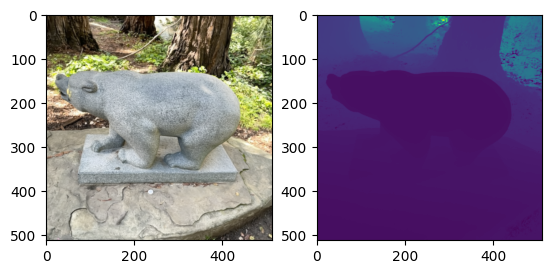

In [14]:
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(depth)

In [20]:
def simple_camera_to_c2w_k(cam):
    cam_pos = - cam.R @ cam.T
    cam_rot = cam.R
    width, height = cam.image_width, cam.image_height
    fy = fov2focal(cam.FoVy, width)
    fx = fov2focal(cam.FoVx, height)
    c2w = torch.eye(4, device='cuda')
    c2w[:3, :3] = torch.from_numpy(cam_rot).to(c2w)
    c2w[:3, 3] = torch.from_numpy(cam_pos).to(c2w)

    K = torch.tensor([
        [fx, 0, width / 2],
        [0, fy, height / 2],
        [0, 0, 1],
    ], device='cuda')
    return c2w, K

def c2w_k_to_simple_camera(c2w, K):
    width, height = K[:2, 2] * 2
    cam_pos = c2w[:3, 3]
    cam_rot = c2w[:3, :3]
    FoVx = focal2fov(K[0, 0], width)
    FoVy = focal2fov(K[1, 1], height)
    cam_R = cam_rot
    cam_T = - cam_R.T @ cam_pos
    
    return Simple_Camera(0, cam_R, cam_T, FoVx, FoVy, height, width, "", 0)


In [21]:
c2w, K = simple_camera_to_c2w_k(cam)

In [23]:
cam_rec = c2w_k_to_simple_camera(c2w.cpu().numpy(), K.cpu().numpy())

In [163]:
norm_argsort = torch.linalg.norm(gaussian._xyz, dim=1).argsort()

In [164]:
p = gaussian._xyz[norm_argsort[0:300000:30]].detach()

In [165]:
p_proj = to_homogeneous(p)
p_proj = (p_proj @ c2w.inverse().T)[:, :3]
p_proj = p_proj @ K.T
p_proj = p_proj[:, :2] / p_proj[:, 2:]

In [166]:
p_proj_orig = project(cam, p)

In [169]:
p_proj - p_proj_orig

tensor([[0.2322, 0.8903],
        [0.1884, 0.8688],
        [0.2649, 0.0392],
        ...,
        [0.4551, 0.1603],
        [0.7110, 0.3734],
        [0.5196, 0.9329]], device='cuda:0')

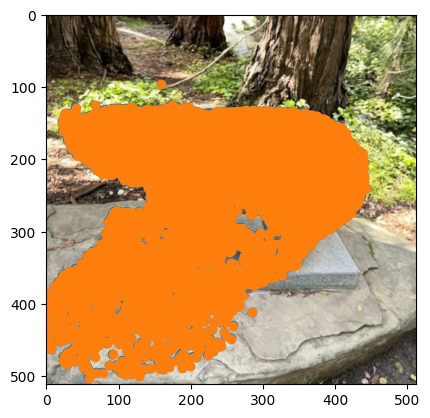

In [167]:
plt.scatter(*p_proj_orig.cpu().T)
plt.scatter(*p_proj.cpu().T)
plt.imshow(img)

In [127]:
from vis_utils import pointcloud_trace
import plotly.graph_objs as go

trace = pointcloud_trace(p.cpu())

# Create a layout for the 3D scene
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    margin=dict(l=0, r=0, b=0, t=0)  # Adjust the margins as needed
)

# Create a figure and plot the data
fig = go.Figure(data=[trace], layout=layout)
fig.show()

## Camera convention testing

In [18]:
RT = torch.eye(4).float()
K = torch.tensor([
    [100, 0, 100],
    [0, 100, 100],
    [0, 0, 1],
]).float()
depth = torch.rand(200, 200)

In [19]:
p = torch.tensor([
    [0, 0],
    [199, 0],
    [0, 199],
    [199, 199],
    [100, 100],
])

In [21]:
p_unproj = unproject(RT, K, p, depth)

In [32]:
p_proj = (to_homogeneous(p_unproj) @ RT.inverse().T)[:, :3] @ K.T
p_proj /= p_proj[:, 2:]
p_proj = p_proj[:, :2]

torch.equal(p, p_proj.int())

True